In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Equation: 

# $$ \frac{dx}{dt} = \lambda x$$

# == Setup ==



# Generator (regression):

<img src="generator.png" width="500">

# Discriminator (classification):

<img src="discriminator.png" width="500">

## Analytic Solutionn

In [2]:
L = -1
analytic = lambda t: np.exp(L*t)

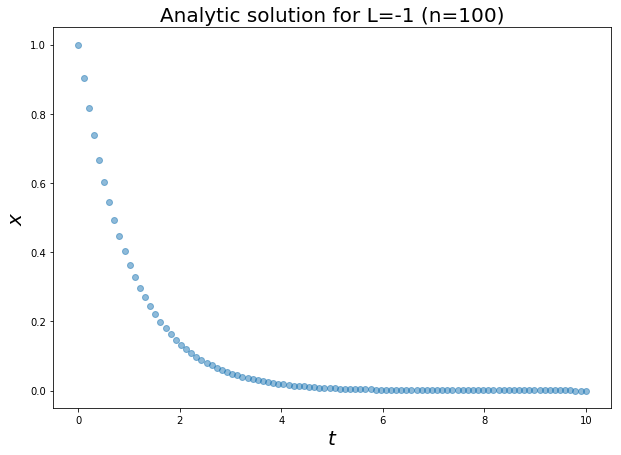

In [3]:
t = np.linspace(0,10,100)
plt.figure(figsize=(10,7))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.plot(t, analytic(t), 'o', alpha=0.5, label='analytic')
plt.title('Analytic solution for L=-1 (n=100)', fontsize=20);

## GAN

In [4]:
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict

In [28]:
class Generator(nn.Module):
    def __init__(self, vec_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(), x0=1):
        super(Generator, self).__init__()
        
        self.x0 = x0
        
        layers = [('lin1', nn.Linear(vec_dim, n_hidden_units)), ('act1', activation)]
        for i in range(n_hidden_layers):
            layer_id = i+2
            layers.append(('lin{}'.format(layer_id), nn.Linear(n_hidden_units, n_hidden_units)))
            layers.append(('act{}'.format(layer_id), activation))
        layers.append(('linout', nn.Linear(n_hidden_units, vec_dim)))
        layers.append(('actout', nn.Tanh()))
        
        layers = OrderedDict(layers)
        self.main = nn.Sequential(layers)
    
    def forward(self, x):
        output = self.main(x)
        return output
    
    def predict(self, t):
        x_pred = self(t)
        x_adj = self.x0 + (1 - torch.exp(-t)) * x_pred
        return x_adj

class Discriminator(nn.Module):
    def __init__(self, vec_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh()):
        super(Discriminator, self).__init__()
        
        layers = [('lin1', nn.Linear(vec_dim, n_hidden_units)), ('act1', activation)]
        for i in range(n_hidden_layers):
            layer_id = i+2
            layers.append(('lin{}'.format(layer_id), nn.Linear(n_hidden_units, n_hidden_units)))
            layers.append(('act{}'.format(layer_id), activation))
        layers.append(('linout', nn.Linear(n_hidden_units, vec_dim)))
        layers.append(('actout', nn.Sigmoid()))
        
        layers = OrderedDict(layers)
        self.main = nn.Sequential(layers)
    
    def forward(self, x):
        output = self.main(x)
        return output

In [34]:
def plot_loss(G_loss, D_loss, ax):
    epochs=np.arange(len(G_loss))
    ax.plot(epochs, np.log(G_loss), label='G Loss')
    ax.plot(epochs, np.log(D_loss), label='D Loss')
    ax.set_title('Loss of D and G')
    ax.set_xlabel('epoch')
    ax.set_ylabel('log-loss')
    ax.legend()

def plot_preds(G, t, analytic, ax):
    ax.plot(t, analytic(t), label='analytic')
    t_torch = tensor(t, dtype=torch.float, requires_grad=True).reshape(-1,1)
    pred = G.predict(t_torch)
    ax.plot(t, pred.detach().numpy().flatten(), '--', label='pred')
    ax.set_title('Pred and Analytic')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.legend()

def plot_losses_and_preds(G_loss, D_loss, G, t, analytic, figsize=(15,5)):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    plot_loss(G_loss, D_loss, ax[0])
    plot_preds(G, t, analytic, ax[1])
    plt.show()

In [43]:
def train(num_epochs, 
          L=-1, 
          g_hidden_units=10, 
          d_hidden_units=10, 
          g_hidden_layers=2, 
          d_hidden_layers=2, 
          d_lr=0.001,
          g_lr=0.001,
          t_low=0, 
          t_high=10, 
          n=100, 
          real_label=1, 
          fake_label=0, 
          logging=True, 
          G_iters=1, 
          D_iters=1):
    """
    function to perform training of generator and discriminator for num_epochs
    """
    
    # initialize nets
    G = Generator(vec_dim=1, 
                  n_hidden_units=g_hidden_units, 
                  n_hidden_layers=g_hidden_layers,
                  activation=nn.LeakyReLU())
    
    D = Discriminator(vec_dim=1, 
                      n_hidden_units=d_hidden_units, 
                      n_hidden_layers=d_hidden_layers,
                      activation=nn.LeakyReLU())
    
    # grid
    t = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    
    # perturb grid
    delta_t = t[1]-t[0]
    def get_batch():
        return t + delta_t * torch.randn_like(t) / 3
#         return t_low + (t_high - t_low ) * torch.rand_like(t, requires_grad=True)
    
    # labels
    real_label_vec = torch.full((n,), real_label).reshape(-1,1)
    fake_label_vec = torch.full((n,), fake_label).reshape(-1,1)
    
    # optimization
    cross_entropy = nn.BCELoss()
    mse = nn.MSELoss()
    wass_loss = lambda y_true, y_pred: torch.mean(y_true * y_pred)
    optiD = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.9, 0.999))
    optiG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.9, 0.999))
    
    # logging
    D_losses = []
    G_losses = []
    
    # sanity check with data from analytic solution
#     real = torch.exp(L*t)
    # sample data from perturb grid
#     def get_real(t):
#         return torch.exp(L*t)
    
#     def deterministic_D(x):
#         # decision boundary == analytic solution
#         classif = []
#         for i, x_i in enumerate(x[0]):
#             if abs(float(x_i) - float(real[0][i])) < .05:
#                 # says real
#                 classif.append(1) 
#             else:
#                 # says fake
#                 classif.append(0)
#         return torch.tensor(classif, dtype=torch.float, requires_grad=True).reshape(-1,1)
#     D = deterministic_D

    for epoch in range(num_epochs):

        ## =========
        ##  TRAIN G
        ## =========
        
        t = get_batch() 
#         real = get_real(t)
        
        for i in range(G_iters):

#             t = torch.randn_like(real) # sample noise

            x_pred = G.predict(t)
            real = L * x_pred

            # compute dx/dt
            fake, = autograd.grad(x_pred, t, 
                                  grad_outputs=real.data.new(real.shape).fill_(1), 
                                  create_graph=True)
            
            optiG.zero_grad()
#             g_loss = wass_loss(D(fake), real_label_vec)
            g_loss = cross_entropy(D(fake), real_label_vec)
#             g_loss = mse(fake, real)
#             g_loss = torch.mean(torch.pow(fake - real, 2))
            g_loss.backward(retain_graph=True)
            optiG.step()
        
        ## =========
        ##  TRAIN D
        ## ========= 

        for i in range(D_iters):
            
#             real = get_real(t) # sample data
#             real_loss = wass_loss(D(real), real_label_vec)
#             fake_loss = wass_loss(D(fake), fake_label_vec)
            real_loss = cross_entropy(D(real), real_label_vec)
            fake_loss = cross_entropy(D(fake), fake_label_vec)

            optiD.zero_grad()
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward(retain_graph=True)
            optiD.step()

        ## ========
        ## Logging
        ## ========
        
        if logging:
            print('[%d/%d] D_Loss : %.4f Loss_G: %.4f' % (epoch, num_epochs, d_loss.item(), g_loss.item()))
        
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        
    return G, D, G_losses, D_losses

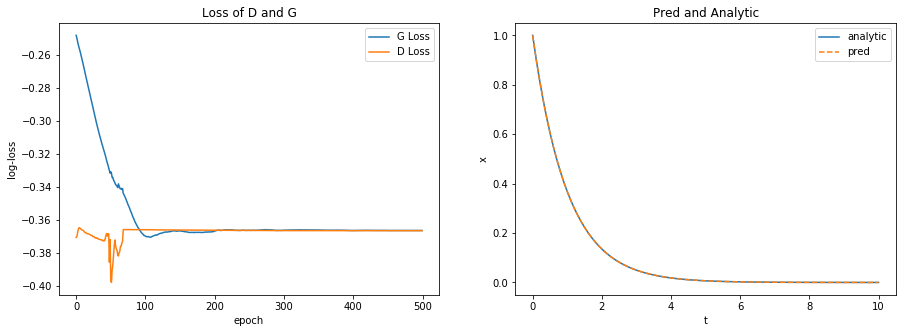

In [46]:
G,D,G_loss,D_loss = train(500, 
                          g_hidden_units=20, 
                          g_hidden_layers=3,
                          d_hidden_units=10, 
                          d_hidden_layers=2,
                          logging=False, 
                          G_iters=10, 
                          D_iters=1, 
                          n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

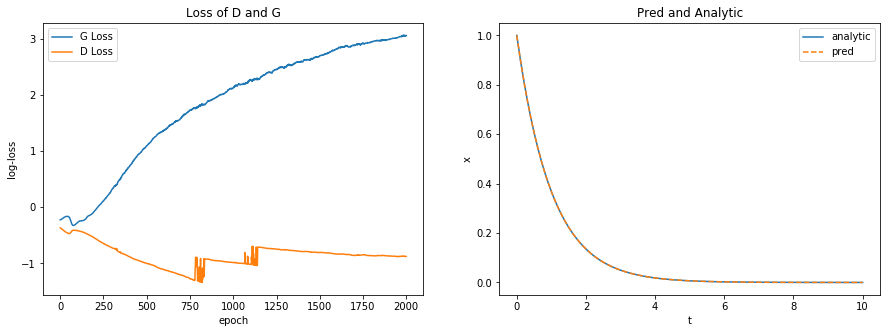

In [35]:
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

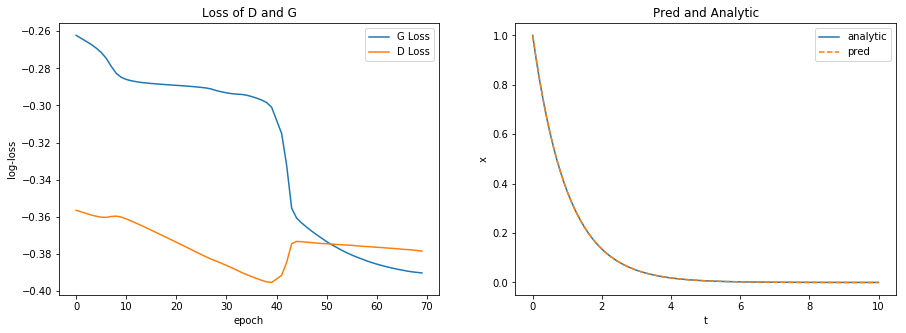

In [40]:
G,D,G_loss,D_loss = train(70, 
                          g_hidden_units=20, 
                          g_hidden_layers=3,
                          d_hidden_units=10, 
                          d_hidden_layers=2,
                          logging=False, 
                          G_iters=10, 
                          D_iters=1, 
                          n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

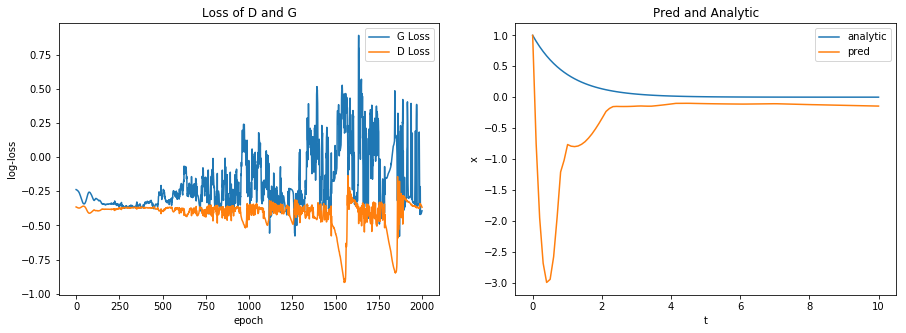

In [22]:
G,D,G_loss,D_loss = train(2000, 
                          g_hidden_units=20, 
                          g_hidden_layers=3,
                          d_hidden_units=10, 
                          d_hidden_layers=2,
                          logging=False, 
                          G_iters=1, 
                          D_iters=1, 
                          n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

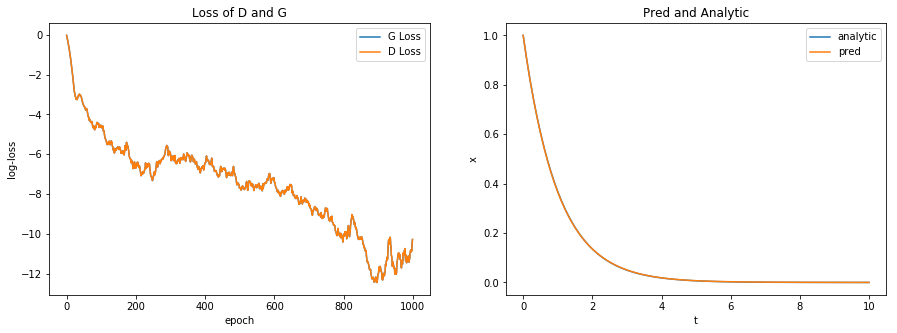

In [8]:
# just trying to solve Lagaris method
G,D,G_loss,D_loss = train(1000, 
                          g_hidden_units=20, 
                          g_hidden_layers=3,
                          d_hidden_units=10, 
                          d_hidden_layers=2,
                          logging=False, 
                          G_iters=1, 
                          D_iters=4, 
                          n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

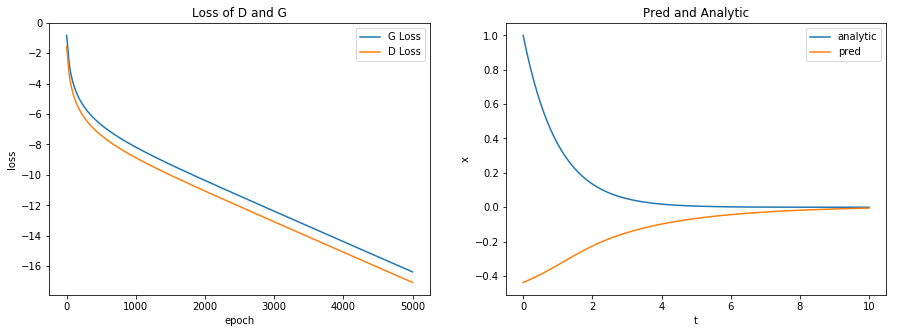

In [28]:
# wasserstein
G,D,G_loss,D_loss = train(5000, 
                          g_hidden_units=20, 
                          g_hidden_layers=3,
                          d_hidden_units=10, 
                          d_hidden_layers=2,
                          logging=False, 
                          G_iters=1, 
                          D_iters=4,
                          n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

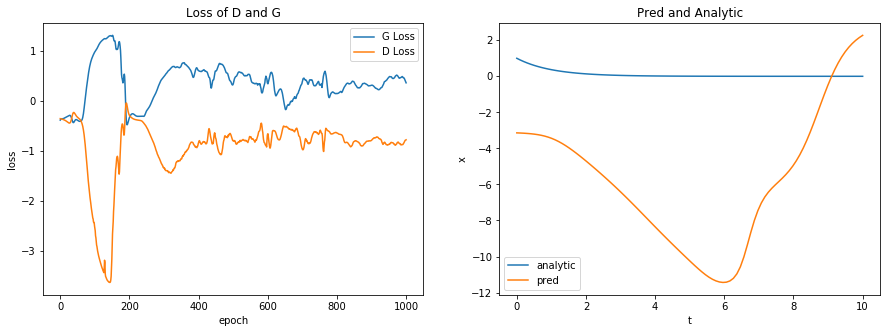

In [25]:
G,D,G_loss,D_loss = train(1000, 
                          g_hidden_units=20, 
                          g_hidden_layers=3,
                          d_hidden_units=10, 
                          d_hidden_layers=2,
                          logging=False, 
                          G_iters=1, 
                          D_iters=4, 
                          n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

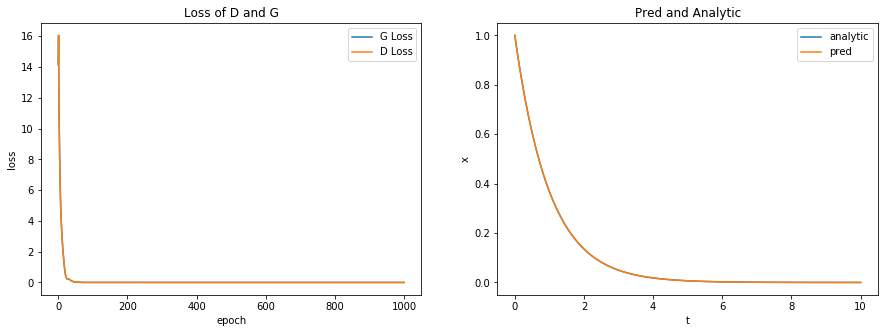

In [144]:
# regression on real
G,D,G_loss,D_loss = train(1000, g_hidden=10, d_hidden=10, logging=False, G_iters=1, D_iters=4, n=100)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

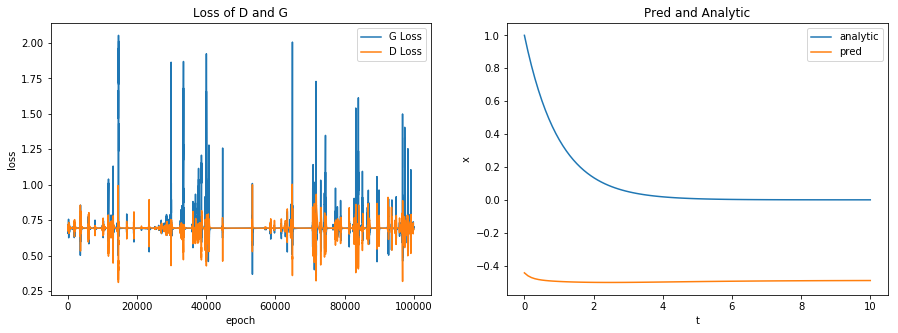

In [108]:
# real grid
G,D,G_loss,D_loss = train(100000, g_hidden=10, d_hidden=10, logging=False, G_iters=1)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

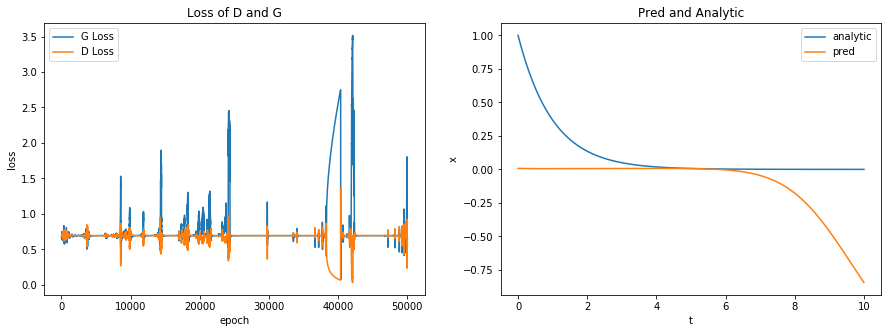

In [107]:
# real grid
G,D,G_loss,D_loss = train(50000, g_hidden=10, d_hidden=10, logging=False, G_iters=1)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

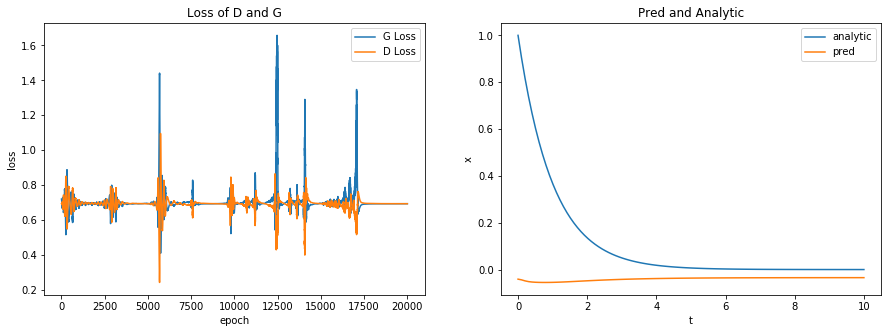

In [106]:
# real grid
G,D,G_loss,D_loss = train(20000, g_hidden=10, d_hidden=10, logging=False, G_iters=1)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

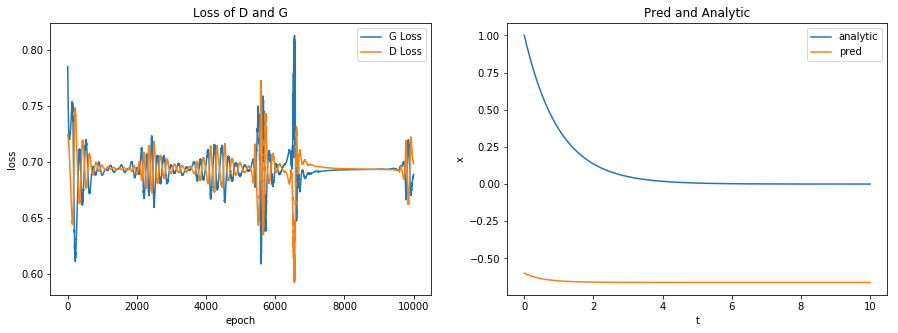

In [105]:
# real grid
G,D,G_loss,D_loss = train(10000, g_hidden=5, d_hidden=5, logging=False, G_iters=1)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

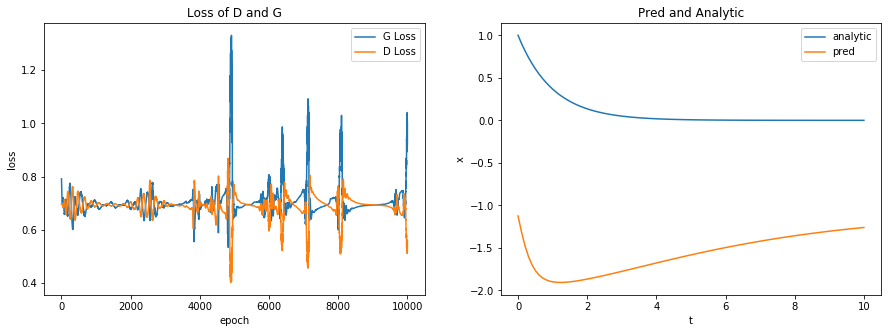

In [104]:
# real grid
G,D,G_loss,D_loss = train(10000, g_hidden=10, d_hidden=10, logging=False, G_iters=1)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

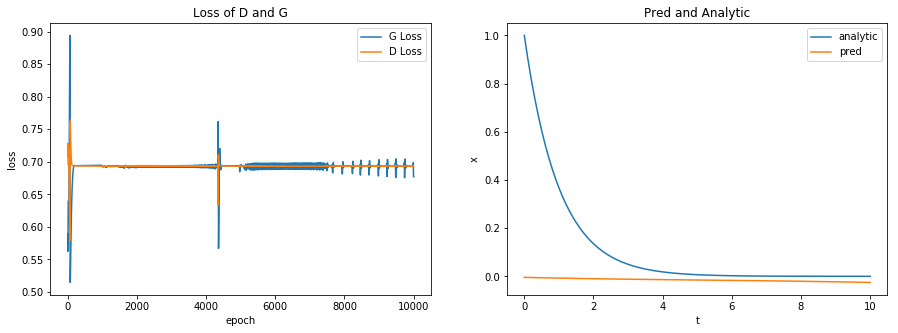

In [96]:
# real grid
G,D,G_loss,D_loss = train(10000, g_hidden=50, d_hidden=10, logging=False, G_iters=10)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

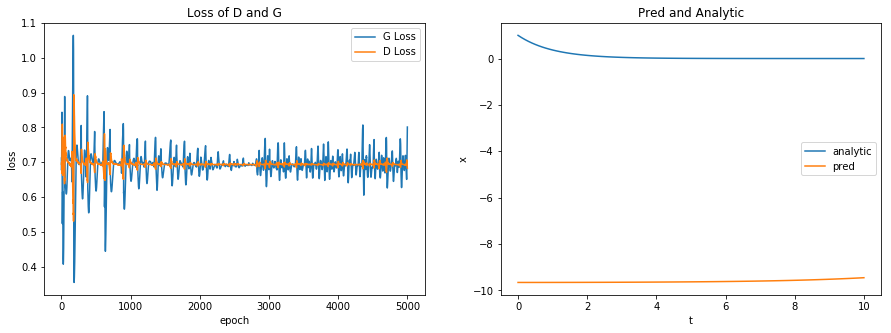

In [99]:
# real samples
G,D,G_loss,D_loss = train(5000, g_hidden=50, d_hidden=50, logging=False, G_iters=10)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

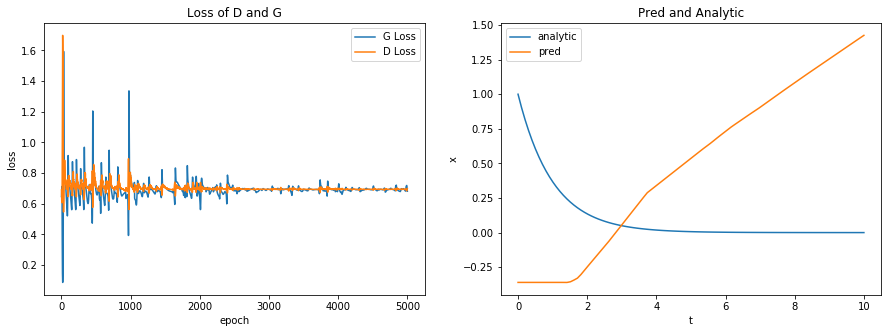

In [101]:
# relu
G,D,G_loss,D_loss = train(5000, g_hidden=50, d_hidden=50, logging=False, G_iters=10)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic)

### Remarks:

...

G_hidden = 5 | D_hidden = 5


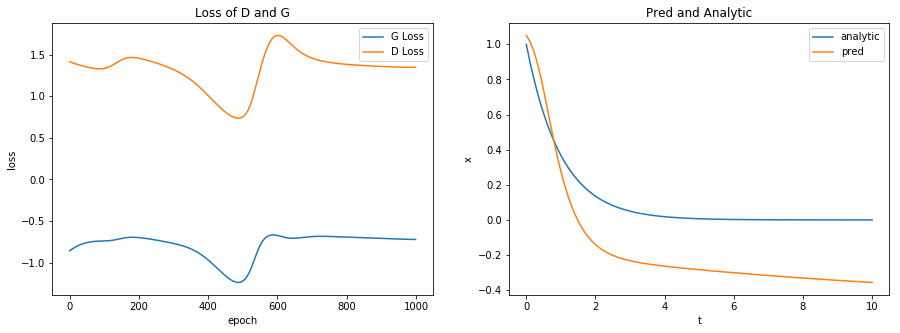

G_hidden = 5 | D_hidden = 10


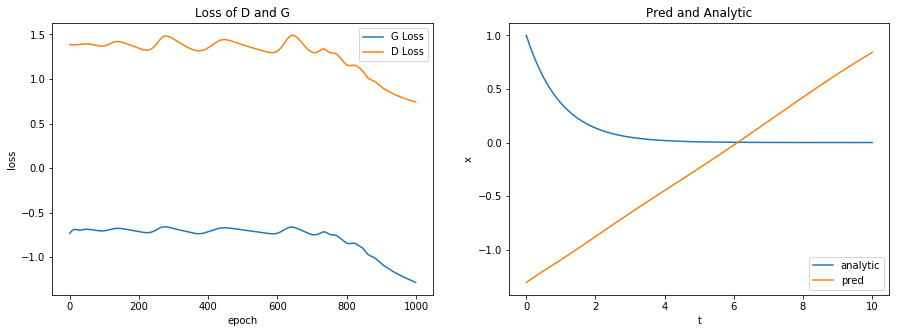

G_hidden = 5 | D_hidden = 20


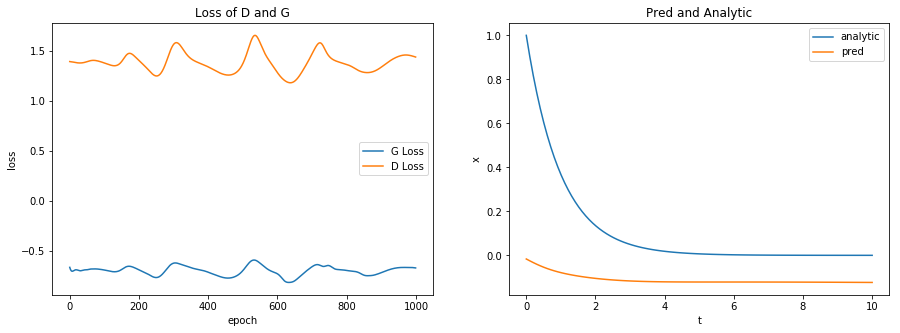

G_hidden = 5 | D_hidden = 30


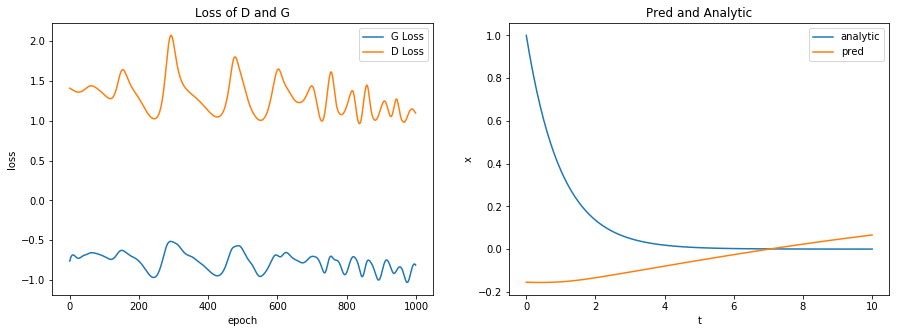

G_hidden = 10 | D_hidden = 5


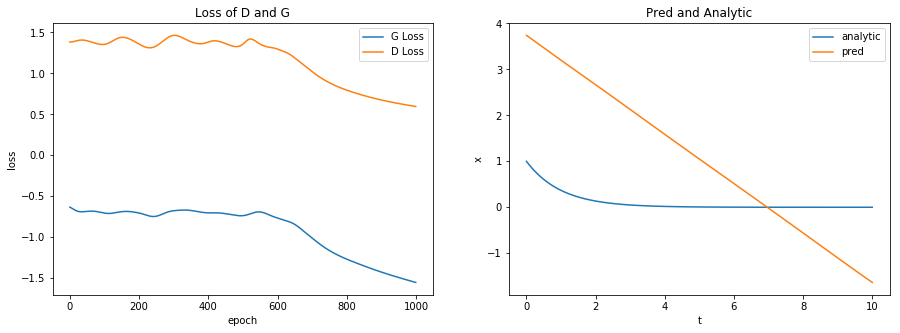

G_hidden = 10 | D_hidden = 10


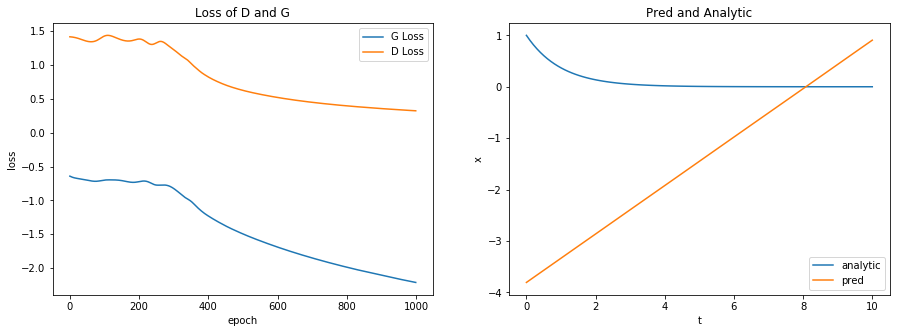

G_hidden = 10 | D_hidden = 20


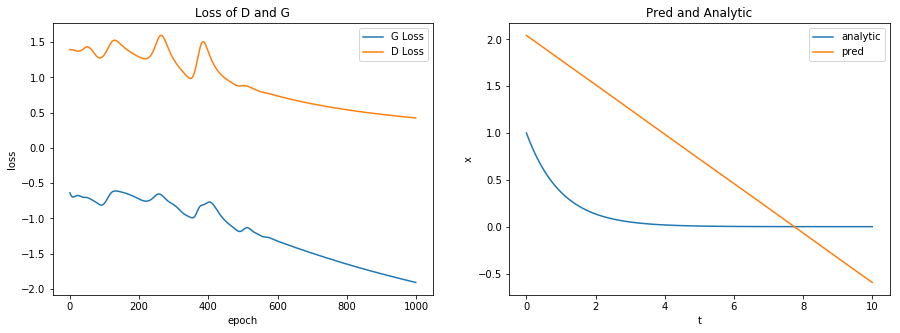

G_hidden = 10 | D_hidden = 30


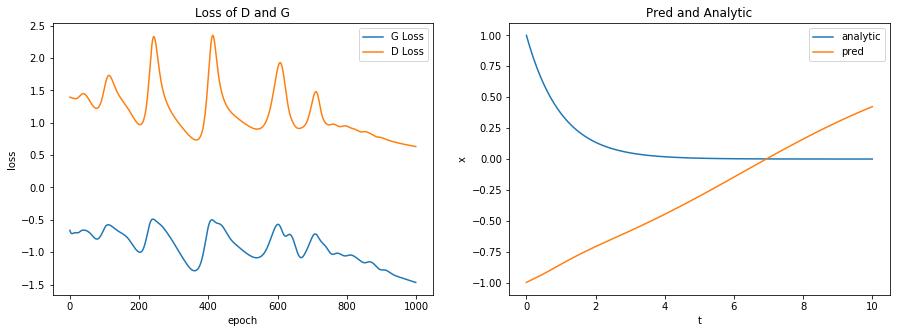

G_hidden = 20 | D_hidden = 5


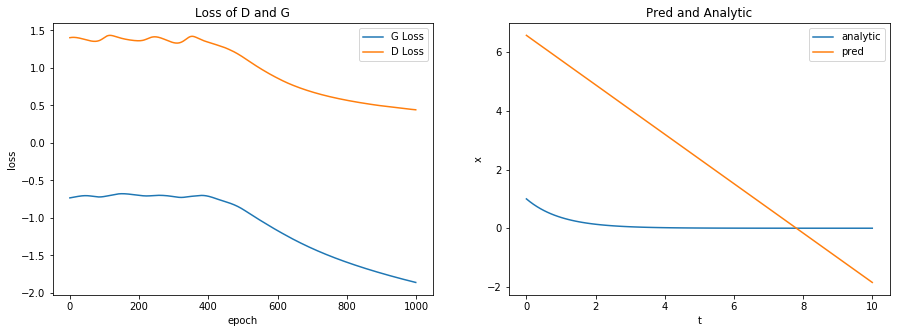

G_hidden = 20 | D_hidden = 10


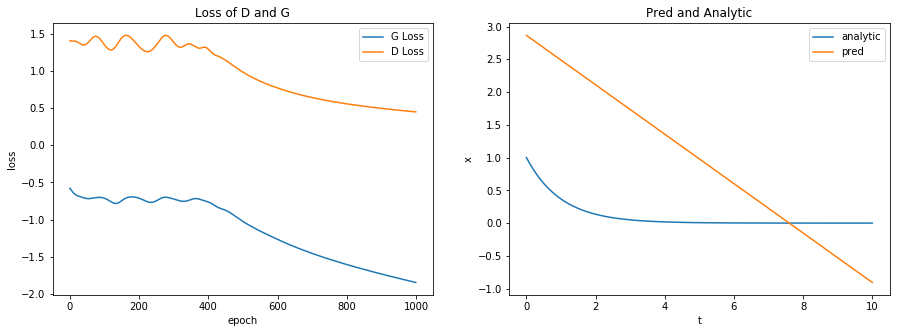

G_hidden = 20 | D_hidden = 20


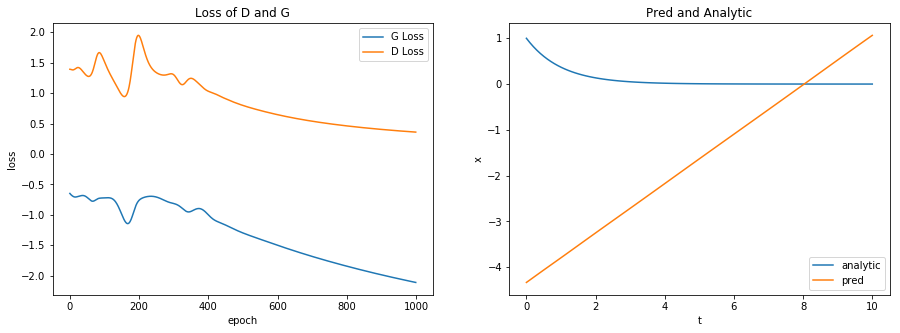

G_hidden = 20 | D_hidden = 30


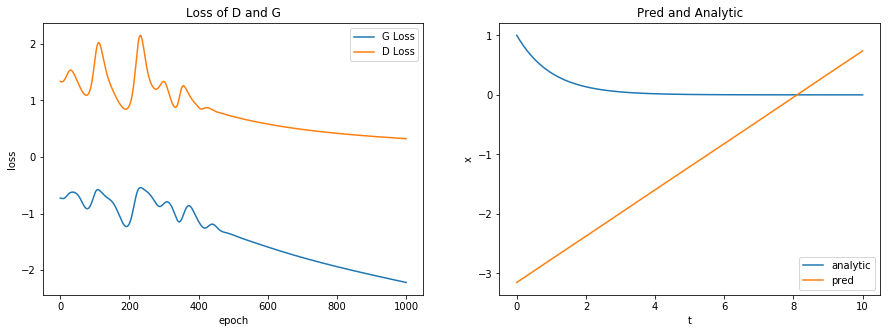

G_hidden = 30 | D_hidden = 5


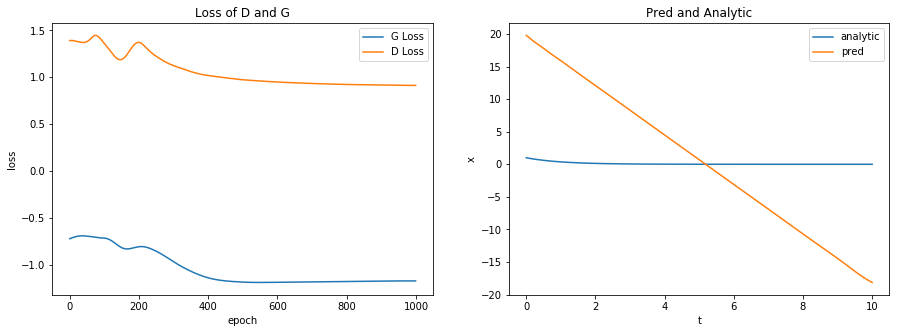

G_hidden = 30 | D_hidden = 10


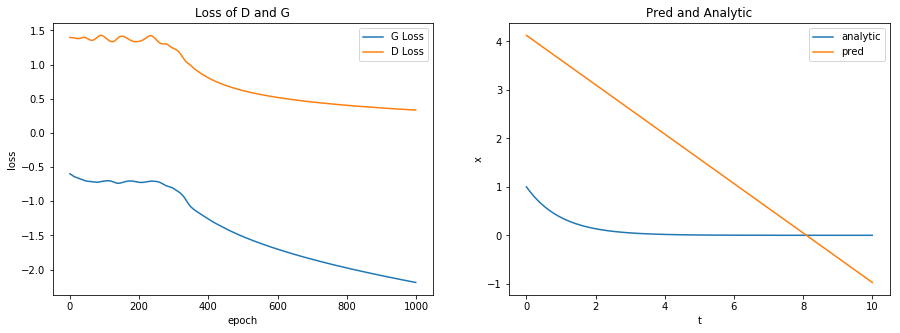

G_hidden = 30 | D_hidden = 20


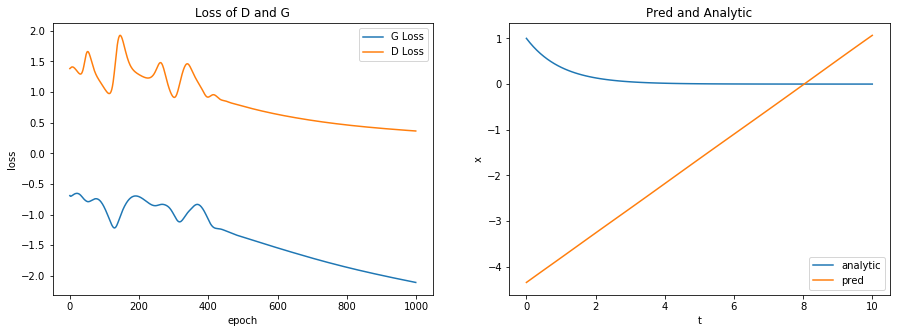

G_hidden = 30 | D_hidden = 30


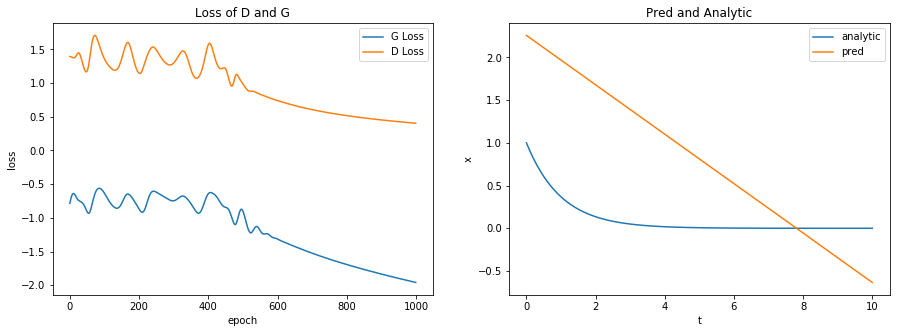

In [12]:
## =============
##  GRID SEARCH
## =============
g_nodes = [5,10,20,30]
d_nodes = [5,10,20,30]
for g_ in g_nodes:
    for d_ in d_nodes:
        G,D,G_loss,D_loss,Dx_vals,DGz1_vals,DGz2_vals = train(L, 1000, g_hidden=g_, d_hidden=d_, logging=False)
        print('G_hidden = {} | D_hidden = {}'.format(g_, d_))
        plot_losses_and_preds(G_loss, D_loss, G, t, analytic)